# Fine-Tuning BERT for Question Answering

This notebook demonstrates the fine-tuning of BERT for the task of question answering. We will use a pre-trained BERT model and adapt it to answer questions based on a given context. The process includes data preparation, model fine-tuning, and evaluation. The dataset used is similar to the Stanford Question Answering Dataset (SQuAD).

## BERT Overview

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model that pre-trains a deep bidirectional representation by jointly conditioning on both left and right context in all layers. This approach allows the model to learn contextual relationships between words in a sentence, making it effective for various NLP tasks, including question answering.

**Original BERT Paper:** [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

**Objective:** Fine-tune BERT to answer questions based on a context paragraph.

## Library Imports

In this section, we import essential libraries for the task:
- `transformers`: Provides pre-trained models and tokenizers for NLP tasks.
- `torch`: PyTorch library for tensor operations and model building.
- `numpy`: For numerical operations.
- `matplotlib`: For plotting and visualizing results.


In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertModel
import matplotlib.pyplot as plt

## Dataset Description

We define the training and testing datasets. Each dataset consists of contexts (paragraphs) and question-answer pairs. The context provides the information from which the answer to the question can be derived.

The dataset format:
- `train_contexts` and `test_contexts`: Lists of context strings.
- `train_questions_answers` and `test_questions_answers`: Lists of dictionaries, each containing a `context_index`, `question`, and `answer`.

The context_index links a question-answer pair to a specific context.

In [2]:
train_contexts = [
    "Nokia C12 Android 12 (Go Edition) Smartphone, All-Day Battery, 4GB RAM (2GB RAM + 2GB Virtual RAM) + 64GB Capacity | Light Mint",
    "Nokia G21 Android Smartphone, Dual SIM, 3-Day Battery Life, 6GB RAM + 128GB Storage, 50MP Triple AI Camera | Nordic Blue",
    "realme narzo 50i Prime (Dark Blue 4GB RAM+64GB Storage) Octa-core Processor | 5000 mAh Battery",
    "realme narzo N53 (Feather Gold, 4GB+64GB) 33W Segment Fastest Charging | Slimmest Phone in Segment | 90 Hz Smooth Display",
    "realme narzo N55 (Prime Blue, 4GB+64GB) 33W Segment Fastest Charging | Super High-res 64MP Primary AI Camera",
    "Redmi 9A Sport (Carbon Black, 2GB RAM, 32GB Storage) | 2GHz Octa-core Helio G25 Processor | 5000 mAh Battery",
    "Redmi 11 Prime 5G (Thunder Black, 4GB RAM, 64GB Storage) | Prime Design | MTK Dimensity 700 | 50 MP Dual Cam | 5000mAh | 7 Band 5G",
    "Redmi 12C (Royal Blue, 4GB RAM, 64GB Storage) | High Performance Mediatek Helio G85 | Big 17cm(6.71) HD+ Display with 5000mAh(typ) Battery",
    "Redmi A1 (Light Green, 2GB RAM 32GB ROM) | Segment Best AI Dual Cam | 5000mAh Battery | Leather Texture Design | Android 12",
    "Samsung Galaxy M04 Light Green, 4GB RAM, 64GB Storage | Upto 8GB RAM with RAM Plus | MediaTek Helio P35 Octa-core Processor | 5000 mAh Battery | 13MP Dual Camera",
    "Samsung Galaxy M13 (Midnight Blue, 4GB, 64GB Storage) | 6000mAh Battery | Upto 8GB RAM with RAM Plus",
    "Tecno Camon 20 (Serenity Blue, 8GB RAM,256GB Storage)|16GB Expandable RAM | 64MP RGBW Rear Camera|6.67 FHD+ Big AMOLED with in-Display Fingerprint Sensor",
]

train_questions_answers = [
    {
        "context_index": 0,
        "question": "What is the operating system of the Nokia C12 smartphone?",
        "answer": "Android 12 (Go Edition)"
    },
    {
        "context_index": 0,
        "question": "How much RAM does the Nokia C12 have?",
        "answer": "4GB"
    },
    {
        "context_index": 0,
        "question": "Does the Nokia C12 have virtual RAM?",
        "answer": "(2GB RAM + 2GB Virtual RAM)"
    },
    {
        "context_index": 0,
        "question": "What is the total capacity of the Nokia C12?",
        "answer": "64GB"
    },
    {
        "context_index": 0,
        "question": "What is the color option available for the Nokia C12?",
        "answer": "Light Mint"
    },
    {
        "context_index": 1,
        "question": "What is the model name of the Nokia smartphone?",
        "answer": "Nokia G21"
    },
    {
        "context_index": 1,
        "question": "What is the operating system of the Nokia G21?",
        "answer": "Android"
    },
    {
        "context_index": 1,
        "question": "How many SIM cards does the Nokia G21 support?",
        "answer": "Dual SIM"
    },
    {
        "context_index": 1,
        "question": "How long is the battery life of the Nokia G21?",
        "answer": "3-Day Battery Life"
    },
    {
        "context_index": 1,
        "question": "How much RAM does the Nokia G21 have?",
        "answer": "6GB"
    },
    {
        "context_index": 1,
        "question": "What is the storage capacity of the Nokia G21?",
        "answer": "128GB"
    },
    {
        "context_index": 1,
        "question": "What is the resolution of the main camera on the Nokia G21?",
        "answer": "50MP"
    },
    {
        "context_index": 1,
        "question": "How many AI cameras does the Nokia G21 have?",
        "answer": "Triple AI Camera"
    },
    {
        "context_index": 1,
        "question": "What is the color option available for the Nokia G21?",
        "answer": "Nordic Blue"
    },
    {
        "context_index": 2,
        "question": "What is the model name of the Realme smartphone?",
        "answer": "Realme narzo 50i Prime"
    },
    {
        "context_index": 2,
        "question": "What is the color option available for the Realme narzo 50i Prime?",
        "answer": "Dark Blue"
    },
    {
        "context_index": 2,
        "question": "How much RAM does the Realme narzo 50i Prime have?",
        "answer": "4GB"
    },
    {
        "context_index": 2,
        "question": "What is the storage capacity of the Realme narzo 50i Prime?",
        "answer": "64GB"
    },
    {
        "context_index": 2,
        "question": "What type of processor does the Realme narzo 50i Prime have?",
        "answer": "Octa-core Processor"
    },
    {
        "context_index": 2,
        "question": "What is the battery capacity of the Realme narzo 50i Prime?",
        "answer": "5000 mAh"
    },
    {
        "context_index": 3,
        "question": "What is the model name of the Realme smartphone?",
        "answer": "Realme narzo N53"
    },
    {
        "context_index": 3,
        "question": "What is the color option available for the Realme narzo N53?",
        "answer": "Feather Gold"
    },
    {
        "context_index": 3,
        "question": "How much RAM does the Realme narzo N53 have?",
        "answer": "4GB"
    },
    {
        "context_index": 3,
        "question": "What is the storage capacity of the Realme narzo N53?",
        "answer": "64GB"
    },
    {
        "context_index": 3,
        "question": "What is the charging speed of the Realme narzo N53?",
        "answer": "33W Segment Fastest Charging"
    },
    {
        "context_index": 3,
        "question": "What is the special feature of the Realme narzo N53 in terms of phone thickness?",
        "answer": "Slimmest Phone in Segment"
    },
    {
        "context_index": 3,
        "question": "What is the refresh rate of the display on the Realme narzo N53?",
        "answer": "90 Hz"
    },
    {
        "context_index": 4,
        "question": "What is the model name of the Realme smartphone?",
        "answer": "Realme narzo N55"
    },
    {
        "context_index": 4,
        "question": "What is the color option available for the Realme narzo N55?",
        "answer": "Prime Blue"
    },
    {
        "context_index": 4,
        "question": "How much RAM does the Realme narzo N55 have?",
        "answer": "4GB"
    },
    {
        "context_index": 4,
        "question": "What is the storage capacity of the Realme narzo N55?",
        "answer": "64GB"
    },
    {
        "context_index": 4,
        "question": "What is the charging speed of the Realme narzo N55?",
        "answer": "33W Segment Fastest Charging"
    },
    {
        "context_index": 4,
        "question": "What is the resolution of the primary AI camera on the Realme narzo N55?",
        "answer": "Super High-res 64MP"
    },
    {
        "context_index": 5,
        "question": "What is the model name of the Redmi smartphone?",
        "answer": "Redmi 9A Sport"
    },
    {
        "context_index": 5,
        "question": "What is the color option available for the Redmi 9A Sport?",
        "answer": "Carbon Black"
    },
    {
        "context_index": 5,
        "question": "How much RAM does the Redmi 9A Sport have?",
        "answer": "2GB"
    },
    {
        "context_index": 5,
        "question": "What is the storage capacity of the Redmi 9A Sport?",
        "answer": "32GB"
    },
    {
        "context_index": 5,
        "question": "What is the processor of the Redmi 9A Sport?",
        "answer": "2GHz Octa-core Helio G25 Processor"
    },
    {
        "context_index": 5,
        "question": "What is the battery capacity of the Redmi 9A Sport?",
        "answer": "5000 mAh"
    },
    {
        "context_index": 6,
        "question": "What is the model name of the Redmi smartphone?",
        "answer": "Redmi 11 Prime 5G"
    },
    {
        "context_index": 6,
        "question": "What is the color option available for the Redmi 11 Prime 5G?",
        "answer": "Thunder Black"
    },
    {
        "context_index": 6,
        "question": "How much RAM does the Redmi 11 Prime 5G have?",
        "answer": "4GB"
    },
    {
        "context_index": 6,
        "question": "What is the storage capacity of the Redmi 11 Prime 5G?",
        "answer": "64GB"
    },
    {
        "context_index": 6,
        "question": "What is the special feature of the Redmi 11 Prime 5G in terms of design?",
        "answer": "Prime Design"
    },
    {
        "context_index": 6,
        "question": "What is the processor of the Redmi 11 Prime 5G?",
        "answer": "MTK Dimensity 700"
    },
    {
        "context_index": 6,
        "question": "What is the resolution of the dual camera on the Redmi 11 Prime 5G?",
        "answer": "50 MP"
    },
    {
        "context_index": 6,
        "question": "What is the battery capacity of the Redmi 11 Prime 5G?",
        "answer": "5000mAh"
    },
    {
        "context_index": 6,
        "question": "How many 5G bands does the Redmi 11 Prime 5G support?",
        "answer": "7 Band 5G"
    },
    {
        "context_index": 7,
        "question": "What is the model name of the Redmi smartphone?",
        "answer": "Redmi 12C"
    },
    {
        "context_index": 7,
        "question": "What is the color option available for the Redmi 12C?",
        "answer": "Royal Blue"
    },
    {
        "context_index": 7,
        "question": "How much RAM does the Redmi 12C have?",
        "answer": "4GB"
    },
    {
        "context_index": 7,
        "question": "What is the storage capacity of the Redmi 12C?",
        "answer": "64GB"
    },
    {
        "context_index": 7,
        "question": "What is the processor of the Redmi 12C?",
        "answer": "High Performance Mediatek Helio G85"
    },
    {
        "context_index": 7,
        "question": "What is the size of the display on the Redmi 12C?",
        "answer": "Big 17cm(6.71) HD+ Display"
    },
    {
        "context_index": 7,
        "question": "What is the battery capacity of the Redmi 12C?",
        "answer": "5000mAh(typ) Battery"
    },
    {
        "context_index": 8,
        "question": "What is the model name of the Redmi smartphone?",
        "answer": "Redmi A1"
    },
    {
        "context_index": 8,
        "question": "What is the color option available for the Redmi A1?",
        "answer": "Light Green"
    },
    {
        "context_index": 8,
        "question": "How much RAM does the Redmi A1 have?",
        "answer": "2GB"
    },
    {
        "context_index": 8,
        "question": "What is the storage capacity of the Redmi A1?",
        "answer": "32GB"
    },
    {
        "context_index": 8,
        "question": "What is the special feature of the camera on the Redmi A1?",
        "answer": "Segment Best AI Dual Cam"
    },
    {
        "context_index": 8,
        "question": "What is the battery capacity of the Redmi A1?",
        "answer": "5000mAh Battery"
    },
    {
        "context_index": 8,
        "question": "What is the design feature of the Redmi A1?",
        "answer": "Leather Texture Design"
    },
    {
        "context_index": 8,
        "question": "What is the operating system of the Redmi A1?",
        "answer": "Android 12"
    },
    {
        "context_index": 9,
        "question": "What is the model name of the Samsung smartphone?",
        "answer": "Samsung Galaxy M04"
    },
    {
        "context_index": 9,
        "question": "What is the color option available for the Samsung Galaxy M04?",
        "answer": "Light Green"
    },
    {
        "context_index": 9,
        "question": "How much RAM does the Samsung Galaxy M04 have?",
        "answer": "4GB"
    },
    {
        "context_index": 9,
        "question": "What is the storage capacity of the Samsung Galaxy M04?",
        "answer": "64GB"
    },
    {
        "context_index": 9,
        "question": "How much RAM can the Samsung Galaxy M04 have with RAM Plus?",
        "answer": "Upto 8GB RAM with RAM Plus"
    },
    {
        "context_index": 9,
        "question": "What is the processor of the Samsung Galaxy M04?",
        "answer": "MediaTek Helio P35 Octa-core Processor"
    },
    {
        "context_index": 9,
        "question": "What is the battery capacity of the Samsung Galaxy M04?",
        "answer": "5000 mAh"
    },
    {
        "context_index": 9,
        "question": "What is the resolution of the dual camera on the Samsung Galaxy M04?",
        "answer": "13MP"
    },
    {
        "context_index": 10,
        "question": "What is the model name of the Samsung smartphone?",
        "answer": "Samsung Galaxy M13"
    },
    {
        "context_index": 10,
        "question": "What is the color option available for the Samsung Galaxy M13?",
        "answer": "Midnight Blue"
    },
    {
        "context_index": 10,
        "question": "How much RAM does the Samsung Galaxy M13 have?",
        "answer": "4GB"
    },
    {
        "context_index": 10,
        "question": "What is the storage capacity of the Samsung Galaxy M13?",
        "answer": "64GB"
    },
    {
        "context_index": 10,
        "question": "What is the battery capacity of the Samsung Galaxy M13?",
        "answer": "6000mAh"
    },
    {
        "context_index": 10,
        "question": "How much RAM can the Samsung Galaxy M13 have with RAM Plus?",
        "answer": "Upto 8GB RAM with RAM Plus"
    },
    {
        "context_index": 11,
        "question": "What is the model name of the Tecno smartphone?",
        "answer": "Tecno Camon 20"
    },
    {
        "context_index": 11,
        "question": "What is the color option available for the Tecno Camon 20?",
        "answer": "Serenity Blue"
    },
    {
        "context_index": 11,
        "question": "How much RAM does the Tecno Camon 20 have?",
        "answer": "8GB"
    },
    {
        "context_index": 11,
        "question": "What is the storage capacity of the Tecno Camon 20?",
        "answer": "256GB"
    },
    {
        "context_index": 11,
        "question": "How much expandable RAM can the Tecno Camon 20 have?",
        "answer": "16GB"
    },
    {
        "context_index": 11,
        "question": "What is the resolution of the rear camera on the Tecno Camon 20?",
        "answer": "64MP RGBW"
    },
    {
        "context_index": 11,
        "question": "What is the size of the display on the Tecno Camon 20?",
        "answer": "6.67 FHD+"
    },
    {
        "context_index": 11,
        "question": "What type of display does the Tecno Camon 20 have?",
        "answer": "Big AMOLED"
    },
    {
        "context_index": 11,
        "question": "What feature is integrated into the display of the Tecno Camon 20?",
        "answer": "In-Display Fingerprint Sensor"
    }
]

In [3]:
test_contexts = [
    "Redmi Note 11 (Space Black, 4GB RAM, 64GB Storage)|90Hz FHD+ AMOLED Display | Qualcomm® Snapdragon™ 680-6nm | 33W Charger Included",
    "Redmi Note 10S (Deep Sea Blue, 6GB RAM, 64GB Storage) - Super Amoled Display | 64 MP Quad Camera | 6 Month Free Screen Replacement (Prime only) |33W Charger Included",
    "Lava Blaze 5G (Glass Green, 6GB RAM, UFS 2.2 128GB Storage) | 5G Ready | 50MP AI Triple Camera | Upto 11GB Expandable RAM | Charger Included | Clean Android (No Bloatware)",
    "Oppo A78 5G (Glowing Black, 8GB RAM, 128 Storage) | 5000 mAh Battery with 33W SUPERVOOC Charger| 50MP AI Camera | 90Hz Refresh Rate | with No Cost EMI/Additional Exchange Offers"
]
 
test_questions_answers = [
    {
        "context_index": 0,
        "question": "What is the model name of the Redmi smartphone?",
        "answer": "Redmi Note 11"
    },
    {
        "context_index": 0,
        "question": "What is the color option available for the Redmi Note 11?",
        "answer": "Space Black"
    },
    {
        "context_index": 0,
        "question": "How much RAM does the Redmi Note 11 have?",
        "answer": "4GB"
    },
    {
        "context_index": 0,
        "question": "What is the storage capacity of the Redmi Note 11?",
        "answer": "64GB"
    },
    {
        "context_index": 0,
        "question": "What is the display feature of the Redmi Note 11?",
        "answer": "90Hz FHD+ AMOLED Display"
    },
    {
        "context_index": 0,
        "question": "What is the processor of the Redmi Note 11?",
        "answer": "Qualcomm Snapdragon 680-6nm"
    },
    {
        "context_index": 0,
        "question": "What is included in the package of the Redmi Note 11?",
        "answer": "33W Charger Included"
    },
    {
        "context_index": 1,
        "question": "What is the model name of the Redmi smartphone?",
        "answer": "Redmi Note 10S"
    },
    {
        "context_index": 1,
        "question": "What is the color option available for the Redmi Note 10S?",
        "answer": "Deep Sea Blue"
    },
    {
        "context_index": 1,
        "question": "How much RAM does the Redmi Note 10S have?",
        "answer": "6GB"
    },
    {
        "context_index": 1,
        "question": "What is the storage capacity of the Redmi Note 10S?",
        "answer": "64GB"
    },
    {
        "context_index": 1,
        "question": "What type of display does the Redmi Note 10S have?",
        "answer": "Super Amoled Display"
    },
    {
        "context_index": 1,
        "question": "What is the resolution of the camera on the Redmi Note 10S?",
        "answer": "64 MP Quad Camera"
    },
    {
        "context_index": 1,
        "question": "What is the special offer for screen replacement on the Redmi Note 10S?",
        "answer": "6 Month Free Screen Replacement (Prime only)"
    },
    {
        "context_index": 1,
        "question": "What is included in the package of the Redmi Note 10S?",
        "answer": "33W Charger Included"
    },
    {
        "context_index": 2,
        "question": "What is the model name of the Lava smartphone?",
        "answer": "Lava Blaze 5G"
    },
    {
        "context_index": 2,
        "question": "What is the color option available for the Lava Blaze 5G?",
        "answer": "Glass Green"
    },
    {
        "context_index": 2,
        "question": "How much RAM does the Lava Blaze 5G have?",
        "answer": "6GB"
    },
    {
        "context_index": 2,
        "question": "What is the storage capacity of the Lava Blaze 5G?",
        "answer": "UFS 2.2 128GB"
    },
    {
        "context_index": 2,
        "question": "Is the Lava Blaze 5G compatible with 5G networks?",
        "answer": "5G Ready"
    },
    {
        "context_index": 2,
        "question": "What is the resolution of the camera on the Lava Blaze 5G?",
        "answer": "50MP AI Triple Camera"
    },
    {
        "context_index": 2,
        "question": "How much expandable RAM does the Lava Blaze 5G support?",
        "answer": "Upto 11GB Expandable RAM"
    },
    {
        "context_index": 2,
        "question": "What is included in the package of the Lava Blaze 5G?",
        "answer": "Charger Included"
    },
    {
        "context_index": 2,
        "question": "What operating system does the Lava Blaze 5G use?",
        "answer": "Clean Android (No Bloatware)"
    },
    {
        "context_index": 3,
        "question": "What is the model name of the Oppo smartphone?",
        "answer": "Oppo A78 5G"
    },
    {
        "context_index": 3,
        "question": "What is the color option available for the Oppo A78 5G?",
        "answer": "Glowing Black"
    },
    {
        "context_index": 3,
        "question": "How much RAM does the Oppo A78 5G have?",
        "answer": "8GB"
    },
    {
        "context_index": 3,
        "question": "What is the storage capacity of the Oppo A78 5G?",
        "answer": "128GB"
    },
    {
        "context_index": 3,
        "question": "What is the battery capacity of the Oppo A78 5G?",
        "answer": "5000 mAh"
    },
    {
        "context_index": 3,
        "question": "What is the charging speed of the Oppo A78 5G?",
        "answer": "33W SUPERVOOC Charger"
    },
    {
        "context_index": 3,
        "question": "What is the resolution of the camera on the Oppo A78 5G?",
        "answer": "50MP AI Camera"
    },
    {
        "context_index": 3,
        "question": "What is the refresh rate of the display on the Oppo A78 5G?",
        "answer": "90Hz Refresh Rate"
    },
    {
        "context_index": 3,
        "question": "Are there any additional offers available for the Oppo A78 5G?",
        "answer": "with No Cost EMI/Additional Exchange Offers"
    }
]

## Setting Seed and Device

To ensure reproducibility, we set a random seed. We also specify the device for training the model.

In [4]:
SEED = 123

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))

## Tokenizer Initialization

We use the `BertTokenizerFast` tokenizer to preprocess the input data. This tokenizer splits the text into tokens that the BERT model can understand and handles the addition of special tokens, padding, and truncation.

In [5]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

C:\Users\ASUS\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Custom BERT Model for Question Answering

We define a custom BERT model class for question answering. This class uses a pre-trained BERT model and adds two linear layers for predicting the start and end positions of the answer.

#### Key Points:
- We load a pre-trained BERT model with 12 layers.
- We add two linear layers to predict the start and end positions of the answer in the context.
- We freeze BERT's embeddings and the first 8 layers to speed up training and reduce memory usage.

In [6]:
class BertBaseForQA(nn.Module):

    def __init__(self):
        super(BertBaseForQA, self).__init__()

        # Load the pretrained BERT model of 12-layers with an uncased vocab.     
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.hidden_size = self.bert.config.hidden_size

        # Task specific output layers - one for the start position and the second for the end position of the answer.
        self.linear_start = nn.Linear(self.hidden_size, 1)
        self.linear_end = nn.Linear(self.hidden_size, 1)

        # Freezing BERT's embeddings.
        for param in list(self.bert.embeddings.parameters()):
            param.requires_grad = False
                
        # Freezing the first 8 layers of BERT.
        for i in range(1, 9):
            for param in list(self.bert.encoder.layer[i].parameters()):
                param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids):
        
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        hidden_states = bert_output[0]

        # Pass the hidden states through the linear layers to get the start and end logits.
        start_logits = self.linear_start(hidden_states).squeeze(-1)
        end_logits = self.linear_end(hidden_states).squeeze(-1) 

        # Producing predictive distribution for the start and end positions.
        start_probs = F.log_softmax(start_logits, dim=1)
        end_probs = F.log_softmax(end_logits, dim=1)

        return start_probs, end_probs

## Generating Data

We process the contexts and question-answer pairs to create a suitable format for training and testing. The `generate_data` function creates lists of questions, contexts, and answers. Each answer is represented by its start position in the context.

In [8]:
def generate_data(contexts, questions_answers):
    questions = []
    contexts_output = []
    answers = []
    
    for i, context in enumerate(contexts):
        qas = []
        for qa in questions_answers:
            if qa["context_index"] == i:
                answer_start = context.find(qa["answer"])
                if answer_start != -1:
                    qas.append({
                        "id": str(len(qas) + 1).zfill(5),
                        "is_impossible": False,
                        "question": qa["question"],
                        "answers": [
                            {
                                "text": qa["answer"],
                                "answer_start": answer_start,
                            }
                        ],
                    })

                    questions.append(qa["question"])
                    contexts_output.append(context)
                    answers.append({
                        "text": qa["answer"],
                        "answer_start": answer_start,
                    })
    
    return questions, contexts_output, answers

train_questions, train_contexts, train_answers = generate_data(train_contexts, train_questions_answers)
test_questions, test_contexts, test_answers = generate_data(test_contexts, test_questions_answers)

## Computing Answer End Index

The `compute_answer_end_index` function calculates the end index of each answer in the context. This is essential for training the model to predict both start and end positions.

In [9]:
def compute_answer_end_index(contexts, answers):
    
    for context, answer in zip(contexts, answers):

        if not answer:   # If the question is unanswerable.
            answer['answer_start'] = 0
            answer['answer_end'] = 0
            continue

        gold_text = answer['text'] 
        start_index = answer['answer_start']

        # Compute the end index of the answer.
        end_index = start_index + len(gold_text)

        if context[start_index:end_index] == gold_text:
            answer['answer_end'] = end_index
        else:
            raise ValueError

compute_answer_end_index(train_contexts, train_answers)
compute_answer_end_index(test_contexts, test_answers)

## Tokenizing Data

We use the tokenizer to encode the contexts and questions into input IDs, attention masks, and token type IDs. These encodings are required for feeding the data into the BERT model.

In [11]:
packed_train = [(context, question) for context, question in zip(train_contexts, train_questions)]

train_encodings = tokenizer.batch_encode_plus(packed_train, max_length=tokenizer.model_max_length,
                                              pad_to_max_length=True, return_token_type_ids=True)

packed_test = [(context, question) for context, question in zip(test_contexts, test_questions)]

test_encodings = tokenizer.batch_encode_plus(packed_test, max_length=tokenizer.model_max_length,
                                            pad_to_max_length=True, return_token_type_ids=True)

## Adding Token Positions

The `add_token_positions` function adds the start and end positions of the answers to the encodings. These positions indicate where the answer starts and ends in the tokenized context.

In [12]:
def add_token_positions(encodings, answers):
    
    start_positions = []
    end_positions = []
    
    for i in range(len(answers)):
        
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(
            encodings.char_to_token(i, answers[i]['answer_end'] - 1))      
        
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(test_encodings, test_answers)

## Creating Custom Dataset

We create a custom dataset class that returns the encodings and their respective labels (start and end positions) when accessed. This class inherits from `torch.utils.data.Dataset`.

In [13]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = CustomDataset(train_encodings)
test_dataset = CustomDataset(test_encodings)

## Creating Data Loaders

We use `DataLoader` to create iterable data loaders for training and testing. This helps in efficient data loading and batching.

In [14]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## Model Training Setup

We initialize the BERT-based model, set up the optimizer (`AdamW`), and define some training parameters such as the number of epochs.

In [15]:
EPOCHS = 10

model = BertBaseForQA()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

ignored_index =tokenizer.model_max_length

model.to(device)

BertBaseForQA(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

## Evaluation Function

The `evaluate` function assesses the model's performance on the test data. It calculates the loss and extracts the predicted answers from the model's outputs.

In [16]:
def evaluate(loader, ignored_index):
    answers = []
    total_dev_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            start_out, end_out = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

            start_loss = F.nll_loss(start_out, start_positions, ignore_index=ignored_index)
            end_loss = F.nll_loss(end_out, end_positions, ignore_index=ignored_index)
            total_loss = (start_loss + end_loss) / 2
            total_dev_loss += total_loss.item()

            start_out = start_out.detach().cpu()
            end_out = end_out.detach().cpu()

            start_predictions = torch.argmax(start_out, dim=1)
            end_predictions = torch.argmax(end_out, dim=1)

            for input_id, start_pred, end_pred in zip(input_ids.tolist(), start_predictions.tolist(), end_predictions.tolist()):
                answer_tokens = input_id[start_pred: end_pred + 1]
                if tokenizer.cls_token_id in answer_tokens:
                    answer_tokens = answer_tokens[1:] if answer_tokens[0] == tokenizer.cls_token_id else answer_tokens
                
                # Convert token IDs to token strings
                answer_tokens_str = tokenizer.convert_ids_to_tokens(answer_tokens)
                answers.append('' if answer_tokens_str == [tokenizer.cls_token_id] else tokenizer.convert_tokens_to_string(answer_tokens_str))
            
    return total_dev_loss / len(loader), answers

## Training Loop

The `train` function handles the training process. It iterates through epochs, performs forward and backward passes, and updates the model's weights. After each epoch, it evaluates the model on the test set and adjusts the learning rate if necessary.

In [17]:
def train(train_loader, test_loader, optimizer, epochs, ignored_index):
    train_epochs_loss = []
    test_epochs_loss = []
    lr = optimizer.param_groups[0]['lr']

    initial_test_loss, _ = evaluate(test_loader, ignored_index)
    print("Initial test Loss: {:.3f}".format(initial_test_loss))

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            start_out, end_out = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

            start_loss = F.nll_loss(start_out, start_positions, ignore_index=ignored_index)
            end_loss = F.nll_loss(end_out, end_positions, ignore_index=ignored_index)
            total_loss = (start_loss + end_loss) / 2

            total_loss.backward()
            optimizer.step()

            total_train_loss += total_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_epochs_loss.append(avg_train_loss)

        model.eval()
        avg_test_loss, predictions = evaluate(test_loader, ignored_index)
        true_answers = [i['text'].lower() for i in test_answers]

        correct_predictions = sum(p == t for p, t in zip(predictions, true_answers))
        accuracy = correct_predictions / len(true_answers)
        
        test_epochs_loss.append(avg_test_loss)

        print("Epoch {}/{} - Train Loss: {:.3f}, Test Loss: {:.3f}, Test Accuracy: {:.3f}".format(epoch + 1, epochs, avg_train_loss, avg_test_loss, accuracy))

        if (epoch + 1) % 2 == 0:
            lr /= 2
            for group in optimizer.param_groups:
                group['lr'] = lr

    return train_epochs_loss, test_epochs_loss

train_epochs_loss, test_epochs_loss = train(train_loader, test_loader, optimizer, epochs=EPOCHS, ignored_index=ignored_index)

Initial test Loss: 6.116
Epoch 1/10 - Train Loss: 4.128, Test Loss: 3.979, Test Accuracy: 0.129
Epoch 2/10 - Train Loss: 2.641, Test Loss: 3.337, Test Accuracy: 0.194
Epoch 3/10 - Train Loss: 1.935, Test Loss: 2.926, Test Accuracy: 0.290
Epoch 4/10 - Train Loss: 1.656, Test Loss: 2.626, Test Accuracy: 0.323
Epoch 5/10 - Train Loss: 1.110, Test Loss: 2.443, Test Accuracy: 0.387
Epoch 6/10 - Train Loss: 0.860, Test Loss: 2.290, Test Accuracy: 0.419
Epoch 7/10 - Train Loss: 0.778, Test Loss: 2.227, Test Accuracy: 0.452
Epoch 8/10 - Train Loss: 0.780, Test Loss: 2.201, Test Accuracy: 0.452
Epoch 9/10 - Train Loss: 0.769, Test Loss: 2.208, Test Accuracy: 0.452
Epoch 10/10 - Train Loss: 0.656, Test Loss: 2.152, Test Accuracy: 0.484


## Plotting Loss

Finally, we plot the training and testing loss for each epoch to visualize the model's learning progress.

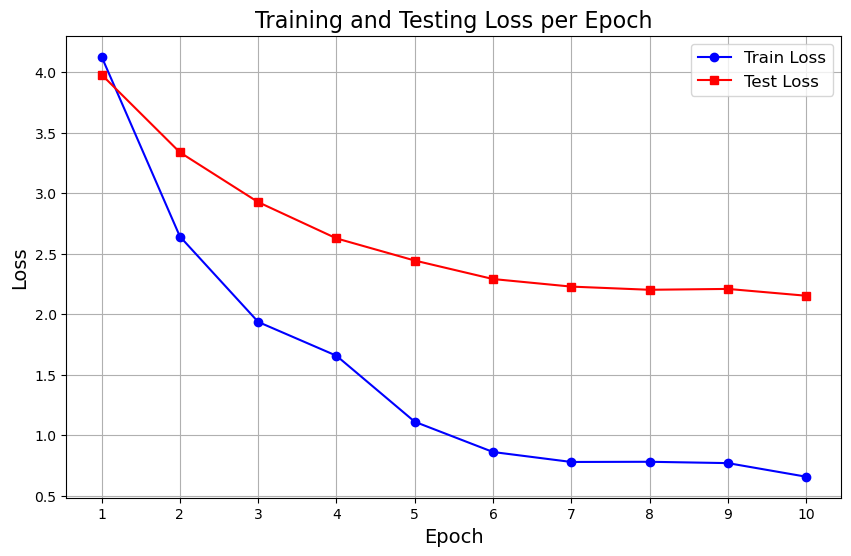

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_epochs_loss, label='Train Loss', marker='o', linestyle='-', color='b')
plt.plot(test_epochs_loss, label='Test Loss', marker='s', linestyle='-', color='r')

plt.title('Training and Testing Loss per Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(len(train_epochs_loss)), range(1, len(train_epochs_loss) + 1))

plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Results

The training process was conducted over 10 epochs, during which both the training loss and test loss were monitored.

1. **Training Loss:** The training loss consistently decreased with each epoch. This trend indicates that the model was effectively learning from the training data and minimizing the error over time.
2. **Test Loss:** The test loss also showed a decreasing trend. However, the decrease in test loss was less steep compared to the training loss, suggesting a gradual improvement in generalization to the test data.
3. **Test Accuracy:** The test accuracy started at a low 0.129 in the first epoch and steadily increased to 0.484 by the end of training. This increase indicates that the model became more adept at correctly identifying the start and end positions of answers in the test set contexts.

The accompanying plot of the training and testing losses provides a visual representation of the model's performance throughout the training epochs. The training loss curve shows a rapid decline, whereas the test loss curve demonstrates a more gradual decrease, indicating the model's improvement on unseen data.

#### Conclusion

The training results demonstrate that the BERT-based model for question answering effectively learns from the training data, as evidenced by the decreasing training loss. The model also shows improvement on the test data, with a significant decrease in test loss and an increase in test accuracy, indicating better generalization over time.